<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Take-notice!" data-toc-modified-id="Take-notice!-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Take notice!</a></span></li><li><span><a href="#Creating-a-function" data-toc-modified-id="Creating-a-function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating a function</a></span><ul class="toc-item"><li><span><a href="#LA-Times-Neighborhoods" data-toc-modified-id="LA-Times-Neighborhoods-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LA Times Neighborhoods</a></span></li><li><span><a href="#Get-Crime-Data-from-LA-Open-Data-Portal" data-toc-modified-id="Get-Crime-Data-from-LA-Open-Data-Portal-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Get Crime Data from LA Open Data Portal</a></span></li><li><span><a href="#Convert-data-to-a-geodataframe" data-toc-modified-id="Convert-data-to-a-geodataframe-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert data to a geodataframe</a></span></li><li><span><a href="#Create-a-two-layer-map" data-toc-modified-id="Create-a-two-layer-map-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create a two layer map</a></span></li><li><span><a href="#Zoom-to-the-points,-not-the-neighborhoods" data-toc-modified-id="Zoom-to-the-points,-not-the-neighborhoods-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Zoom to the points, not the neighborhoods</a></span></li></ul></li><li><span><a href="#Function-time" data-toc-modified-id="Function-time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Function time</a></span><ul class="toc-item"><li><span><a href="#Adding-more-arguments" data-toc-modified-id="Adding-more-arguments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Adding more arguments</a></span></li></ul></li></ul></div>

<div class="alert alert-danger">

<h1>Take notice!</h1>
<ul>
    <li>Make sure you are working with a copy and not the original notebook file</li>
    <li>This class will be recorded</li>
</ul>
    
</div>

# Creating a function


We have focused on data exploration on single dataframes, geared to create map visualizations for individual layers. This lab goes over *overlays*, creating a single map that has multiple layers of data.

Research inquiry: Which neighborhoods in Los Angeles have the highest instances of arrests?

## LA Times Neighborhoods

* [About mapping LA neighborhoods](http://maps.latimes.com/neighborhoods/)
* [Download the data](http://boundaries.latimes.com/sets/)

In [1]:
import geopandas as gpd

# for basemaps
import contextily as ctx

In [2]:
# get neighborhood boundaries from the LA Times
neighborhoods = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson')

In [3]:
# trim the data to the bare minimum columns
neighborhoods = neighborhoods[['name','geometry']]
neighborhoods.head()

,name,geometry
0,Acton,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,Adams-Normandie,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,Agoura Hills,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,Agua Dulce,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,Alhambra,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


In [4]:
# get the layers into a web mercator projection
# reproject to web mercator
neighborhoods = neighborhoods.to_crs(epsg=3857)

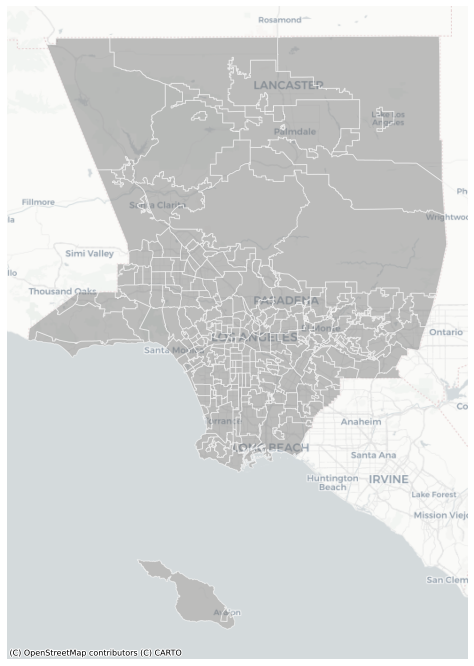

In [8]:
# plot it!
ax=neighborhoods.plot(figsize=(12,12),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


## Get Crime Data from LA Open Data Portal
Next, we acquire the data using the socrata API. Use the socrata documentation to grab the code syntax for our crime data.
- https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72

In [9]:
import pandas as pd
import plotly.express as px
from sodapy import Socrata

In [10]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("amvf-fr72", 
                     limit=5000,
                     where = "arst_date between '2020-09-01T00:00:00' and '2020-09-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

# print it with .sample, which gives you random rows
df.head()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,dispo_desc,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst
0,6019649,BOOKING,2020-09-26T00:00:00.000,1340,02,Rampart,0269,29,M,B,...,MISDEMEANOR COMPLAINT FILED,1200 W 7TH ST,34.0515,-118.2658,"{'type': 'Point', 'coordinates': [-118.2658, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,NaN
1,6019527,BOOKING,2020-09-26T00:00:00.000,0615,14,Pacific,1494,26,M,B,...,NaN,400 WORLD WAY WY,33.942,-118.4095,"{'type': 'Point', 'coordinates': [-118.4095, 3...",2020-09-26T00:00:00.000,0819,PACIFIC,4214,NaN
2,6019650,BOOKING,2020-09-26T00:00:00.000,1250,07,Wilshire,0702,53,M,W,...,NaN,SIERRA BONITA,34.0837,-118.3543,"{'type': 'Point', 'coordinates': [-118.3543, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,MELROSE
3,6019578,BOOKING,2020-09-26T00:00:00.000,0920,15,N Hollywood,1531,41,M,H,...,MISDEMEANOR COMPLAINT FILED,WHITSETT,34.1758,-118.4052,"{'type': 'Point', 'coordinates': [-118.4052, 3...",2020-09-26T00:00:00.000,1120,VALLEY - JAIL DIV,4279,HATTERAS
4,6019399,BOOKING,2020-09-26T00:00:00.000,0105,01,Central,0163,19,M,W,...,MISDEMEANOR COMPLAINT FILED,9TH,34.043,-118.2571,"{'type': 'Point', 'coordinates': [-118.2571, 3...",2020-09-26T00:00:00.000,0225,METRO - JAIL DIVISION,4273,HILL


In [11]:
df.shape

(4360, 25)

In [12]:
# columns
list(df)

['rpt_id',
 'report_type',
 'arst_date',
 'time',
 'area',
 'area_desc',
 'rd',
 'age',
 'sex_cd',
 'descent_cd',
 'chrg_grp_cd',
 'grp_description',
 'arst_typ_cd',
 'charge',
 'chrg_desc',
 'dispo_desc',
 'location',
 'lat',
 'lon',
 'location_1',
 'bkg_date',
 'bkg_time',
 'bgk_location',
 'bkg_loc_cd',
 'crsst']

## Convert data to a geodataframe

Geopandas allows us to convert different types of data into a spatial format.
- https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [13]:
# convert pandas dataframe to geodataframe
crime = gpd.GeoDataFrame(df, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(df.lon, df.lat))

In [14]:
# get the layers into a web mercator projection
# reproject to web mercator
crime = crime.to_crs(epsg=3857)

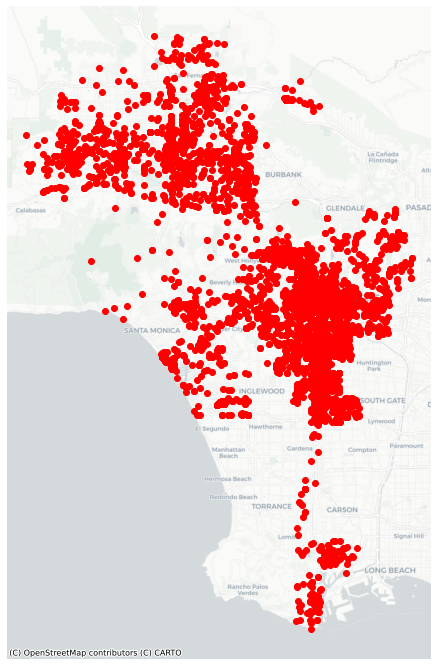

In [15]:
# map it!
ax = crime.plot(figsize=(12,12),color='red')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


## Create a two layer map

- https://geopandas.org/mapping.html

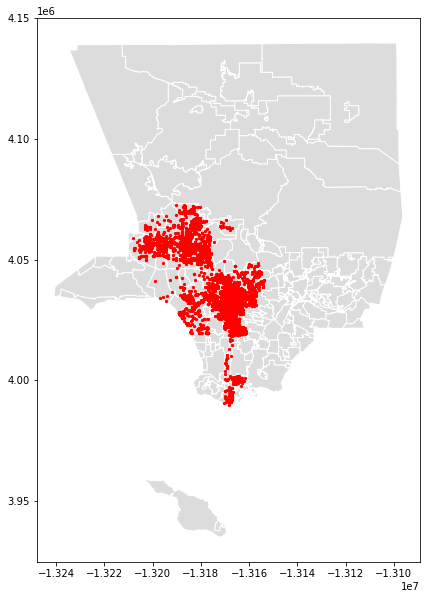

In [16]:
# first define which layers will be your "base"
base = neighborhoods.plot(figsize=(12,10),color='gainsboro', edgecolor='white')

# define the layer that will go on top, and add the base layer to the `ax` argument
ax = crime.plot(ax=base, color='red', markersize=5)

## Zoom to the points, not the neighborhoods

By default, the map has zoomed out to fit both layers. Sometimes, we may want to zoom to the extent of a smaller layer, in this case, the crime data.

In [17]:
# get the bounding box coordinates for the crime data
crime.geometry.total_bounds

array([-13208024.18677467,   3989526.81108362, -13154011.96984178,
         4072673.79123764])

In [18]:
# shortcut to put them into their own variables
minx, miny, maxx, maxy = crime.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)


-13208024.186774671
-13154011.969841776
3989526.8110836204
4072673.7912376425


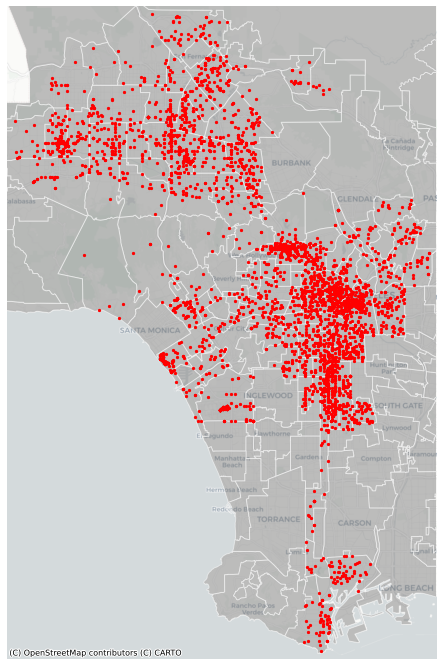

In [22]:
# use the bounding box coordinates to set the x and y limits
base = neighborhoods.plot(figsize=(12,12),
                          color='gray', 
                          edgecolor='white',
                          alpha=0.5)

ax = crime.plot(ax=base, 
                color='red', 
                markersize=5
               )

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

ax

# Function time

Before you create a function, make sure it "works." The following cell presumes a location-"Downtown"- that creates a crime map.

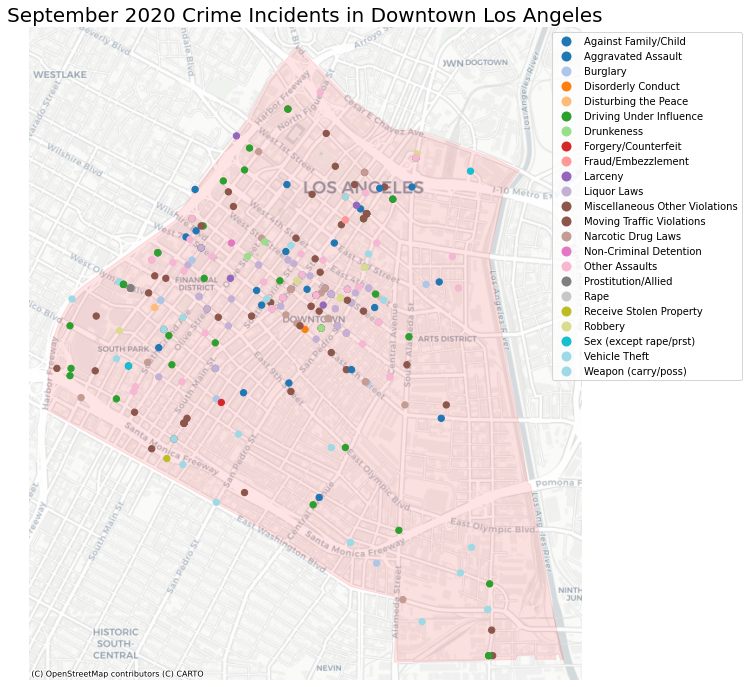

In [23]:
# subset the neighborhoods geodataframe for a single neighborhood
neighborhood = neighborhoods[neighborhoods.name=='Downtown']

# use the bounding box coordinates to set the x and y limits
minx, miny, maxx, maxy = neighborhood.geometry.total_bounds

# do a spatial join to get crime in neighborhood
crime_in_neighborhood = gpd.sjoin(crime,neighborhood,how='inner')

# define the base layer to be the neighborhood polygon
base = neighborhood.plot(figsize=(12,12),
                         color='red', 
                         edgecolor='red',
                         alpha=0.1)

# add the crime data, making sure to add the neighborhood polygon
ax = crime_in_neighborhood.plot(ax=base, 
                                column='grp_description', 
                                markersize=40, 
                                legend=True,
                                cmap='tab20',
                                legend_kwds={
                                   'loc': 'upper right',
                                   'bbox_to_anchor':(1.3,1)
                                }                  # this puts the legend to the side
                            )

# set the map extent to the extent of the neighborhood bounds
ax.set_xlim(minx - 200, maxx + 200) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 200, maxy + 200)

# turn off the axis
ax.axis('off')

# add a title
ax.set_title('September 2020 Crime Incidents in '+neighborhood.name.values[0]+' Los Angeles',fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
ax

Now that you know the code above generates the desired output, convert it into a function. Try it in the cell below, by adding the code above below the function declaration `def map_crime_by_neighborhood(place='Downtown'):` and make sure to indent the content inside the function (you can select multiple lines and hit the tab key).

Finally, make sure to replace `'Downtown'` with `place` (without the single quotes) to ensure that the variable for place is passed onto the functon.

In [24]:
def map_crime_by_neighborhood(place='Downtown'):


SyntaxError: unexpected EOF while parsing (<ipython-input-24-1cc2ef00372b>, line 1)

In [25]:
# call the function!
map_crime_by_neighborhood(place='Hollywood')

NameError: name 'map_crime_by_neighborhood' is not defined

## Adding more arguments

In [34]:
def map_crime_by_neighborhood(place='Downtown', column='grp_description'):
    # subset the neighborhoods geodataframe for a single neighborhood
    neighborhood = neighborhoods[neighborhoods.name==place]

    # use the bounding box coordinates to set the x and y limits
    minx, miny, maxx, maxy = neighborhood.geometry.total_bounds

    # do a spatial join to get crime in neighborhood
    crime_in_neighborhood = gpd.sjoin(crime,neighborhood,how='inner')

    # define the base layer to be the neighborhood polygon
    base = neighborhood.plot(figsize=(12,12),
                             color='red', 
                             edgecolor='red',
                             alpha=0.2)

    # add the crime data, making sure to add the neighborhood polygon
    ax = crime_in_neighborhood.plot(ax=base, 
                                    column=column, 
                                    markersize=40, 
                                    legend=True,
                                    cmap='tab20',
                                    legend_kwds={
                                       'loc': 'upper right',
                                       'bbox_to_anchor':(1.3,1)
                                    }                  # this puts the legend to the side
                                )

    # set the map extent to the extent of the neighborhood bounds
    ax.set_xlim(minx - 200, maxx + 200) # added/substracted value is to give some margin around total bounds
    ax.set_ylim(miny - 200, maxy + 200)

    # turn off the axis
    ax.axis('off')

    # add a title
    ax.set_title('September 2020 Crime Incidents in '+neighborhood.name.values[0]+' Los Angeles',fontsize=20)

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    ax

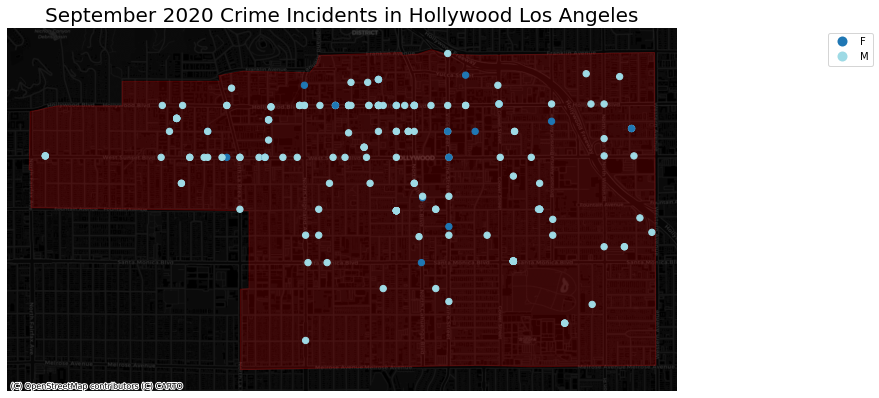

In [35]:
# run the function
map_crime_by_neighborhood(place='Hollywood',column='sex_cd')